In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

from wordfreq import top_n_list

print(sys.executable)
print("pandas:", pd.__version__)

/Users/lwysocki/Documents/mimuw/python-programming-course/WikiScraper/.venv/bin/python
pandas: 3.0.0


## Language confidence score

W tym notatniku implementuję funkcję `lang_confidence_score(text, language, top_words)`, która zwraca prosty wskaźnik „jak bardzo” dany tekst przypomina wybrany język.

1. Tokenizuję tekst na słowa (unicode), normalizuję zapis i usuwam bardzo krótkie tokeny.
2. Dla danego języka biorę listę `top_words` (top-k najczęstszych słów w tym języku).
3. Definiuję wynik jako:

**score = (liczba tokenów z tekstu, które należą do top-k słów języka) / (liczba wszystkich tokenów w tekście)**

Wynik jest w zakresie `[0, 1]`. Intuicja: tekst w danym języku powinien zawierać dużo typowych, częstych słów tego języka.

## Effect of k (rozmiaru listy top-words)

Parametr `k` ma duży wpływ na wynik:

- Dla małego `k` (np. 3, 10) zbiór top-words jest bardzo mały, więc score bywa niski i mocno zależy od tego, czy w krótkim tekście trafią się akurat te najczęstsze słowa.
- Gdy `k` rośnie (np. 100, 1000), zbiór zawiera znacznie więcej popularnych słów, więc rośnie szansa dopasowania i **score zwykle rośnie**.

W eksperymencie dla języków `en`, `pl`, `de` obserwuję wzrost średniego score wraz z `k`, co jest zgodne z intuicją.

In [3]:
import re
import unicodedata

_word_re = re.compile(r"[^\W\d_]+", re.UNICODE)

def tokenize(text: str) -> list[str]:
    text = unicodedata.normalize("NFKC", text)
    toks = [m.group(0).lower() for m in _word_re.finditer(text)]
    toks = [t for t in toks if len(t) >= 2]
    return toks

def lang_confidence_score(text: str, language: str, top_words: list[str]) -> float:
    """
    Score = fraction of tokens in `text` that appear in `top_words` (top-k of `language`).
    Returns 0.0 if there are no tokens.
    """
    tokens = tokenize(text)
    if not tokens:
        return 0.0

    top_set = set(top_words)
    hits = sum(1 for t in tokens if t in top_set)
    return hits / len(tokens)

In [4]:
samples = {
    "en": [
        "Pikachu is an Electric-type Pokémon introduced in Generation I.",
        "This project analyzes word frequencies and compares them with a language reference.",
        "In software engineering, tests help verify that code behaves correctly."
    ],
    "pl": [
        "W tym projekcie analizujemy częstość występowania słów w tekście.",
        "Dzisiaj jest chłodno, ale jutro ma być cieplej i słonecznie.",
        "Programowanie w Pythonie jest wygodne, bo ma dużo bibliotek."
    ],
    "de": [
        "In diesem Projekt untersuchen wir die Häufigkeit von Wörtern im Text.",
        "Heute ist das Wetter kühl, aber morgen soll es sonnig werden.",
        "Programmieren in Python ist praktisch, weil es viele Bibliotheken gibt."
    ],
}

In [5]:
ks = [3, 10, 100, 1000]

rows = []
for lang, texts in samples.items():
    for k in ks:
        top_words = top_n_list(lang, k)
        for i, text in enumerate(texts, start=1):
            score = lang_confidence_score(text, lang, top_words)
            rows.append({
                "language": lang,
                "k": k,
                "sample": i,
                "score": score,
                "tokens": len(tokenize(text)),
            })

df = pd.DataFrame(rows)
df

,language,k,sample,score,tokens
0,en,3,1,0.000000,9
1,en,3,2,0.090909,11
2,en,3,3,0.000000,10
3,en,10,1,0.222222,9
4,en,10,2,0.090909,11
5,en,10,3,0.200000,10
6,en,100,1,0.333333,9
7,en,100,2,0.363636,11
8,en,100,3,0.200000,10
9,en,1000,1,0.444444,9


In [6]:
summary = (
    df.groupby(["language", "k"])
      .agg(mean_score=("score", "mean"), std_score=("score", "std"))
      .reset_index()
)
summary

,language,k,mean_score,std_score
0,de,3,0.030303,0.052486
1,de,10,0.187879,0.010497
2,de,100,0.436364,0.031492
3,de,1000,0.684848,0.073481
4,en,3,0.030303,0.052486
5,en,10,0.171044,0.070283
6,en,100,0.298990,0.087056
7,en,1000,0.493603,0.125616
8,pl,3,0.000000,0.000000
9,pl,10,0.078704,0.068512


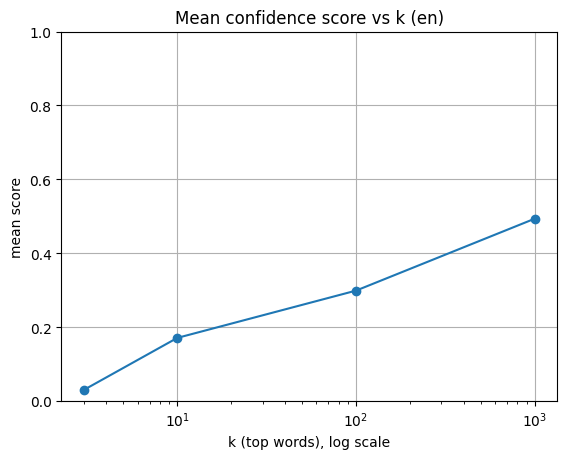

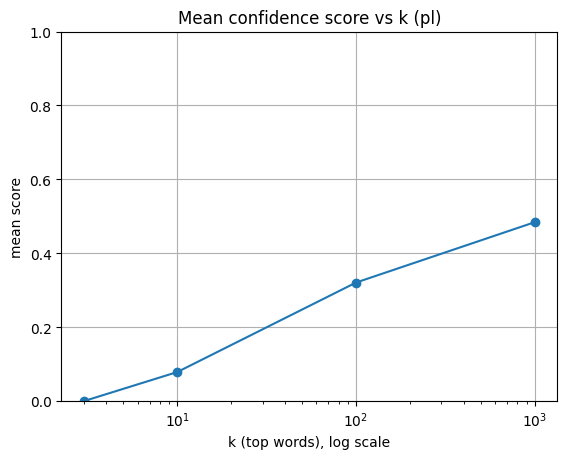

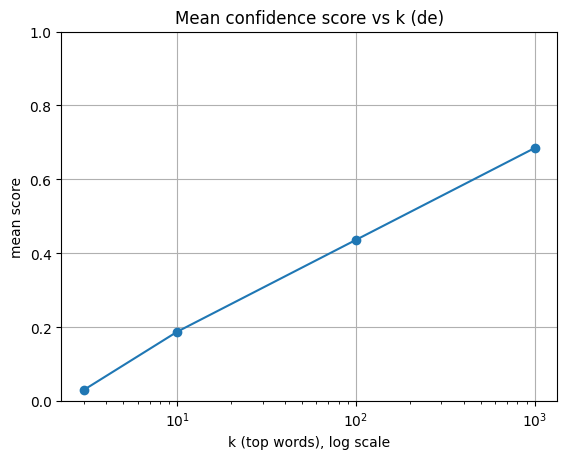

In [7]:
for lang in ["en", "pl", "de"]:
    sub = summary[summary["language"] == lang].sort_values("k")
    plt.figure()
    plt.plot(sub["k"], sub["mean_score"], marker="o")
    plt.xscale("log")
    plt.ylim(0, 1)
    plt.title(f"Mean confidence score vs k ({lang})")
    plt.xlabel("k (top words), log scale")
    plt.ylabel("mean score")
    plt.grid(True)
    plt.show()

In [8]:
ks2 = [10, 100, 1000]  # wystarczy
langs = ["en", "pl", "de"]

rows2 = []
for true_lang, texts in samples.items():
    for i, text in enumerate(texts, start=1):
        for k in ks2:
            top = {lang: top_n_list(lang, k) for lang in langs}
            for lang in langs:
                rows2.append({
                    "true_language": true_lang,
                    "sample": i,
                    "tested_language": lang,
                    "k": k,
                    "score": lang_confidence_score(text, lang, top[lang]),
                })

df2 = pd.DataFrame(rows2)
pivot = df2.pivot_table(index=["true_language","sample"], columns=["tested_language","k"], values="score")
pivot

tested_language             de                            en            \
k                         10        100       1000      10        100    
true_language sample                                                     
de            1       0.181818  0.454545  0.727273  0.090909  0.090909   
              2       0.181818  0.454545  0.727273  0.000000  0.000000   
              3       0.200000  0.400000  0.600000  0.100000  0.100000   
en            1       0.111111  0.222222  0.333333  0.222222  0.333333   
              2       0.000000  0.000000  0.090909  0.090909  0.363636   
              3       0.100000  0.100000  0.100000  0.200000  0.200000   
pl            1       0.000000  0.000000  0.000000  0.000000  0.000000   
              2       0.000000  0.000000  0.000000  0.000000  0.000000   
              3       0.000000  0.000000  0.000000  0.000000  0.000000   

tested_language                       pl                      
k                         1000      10        100       1000  
true_language sample                                          
de            1       0.181818  0.000000  0.000000  0.272727  
              2       0.000000  0.000000  0.000000  0.000000  
              3       0.100000  0.000000  0.000000  0.100000  
en            1       0.444444  0.000000  0.000000  0.111111  
              2       0.636364  0.000000  0.000000  0.090909  
              3       0.400000  0.000000  0.000000  0.100000  
pl            1       0.000000  0.000000  0.142857  0.285714  
              2       0.000000  0.111111  0.444444  0.666667  
              3       0.000000  0.125000  0.375000  0.500000

## Limitations (ograniczenia metody)

To jest bardzo prosty, interpretowalny baseline, więc ma naturalne ograniczenia:

- Nie analizuje gramatyki ani semantyki — opiera się tylko na obecności popularnych słów.
- Działa gorzej dla bardzo krótkich tekstów (mało tokenów → duża wariancja).
- Teksty specjalistyczne, pełne nazw własnych lub terminów rzadkich mogą mieć niski score nawet w „poprawnym” języku.
- Języki mogą dzielić część tokenów (np. zapożyczenia), co może podnosić score dla „nie tego” języka.
- Wynik zależy od tokenizacji i normalizacji (diakrytyki, apostrofy, zapis znaków).

Możliwe ulepszenia: n-gramy znakowe/słowne, modele statystyczne lub klasyfikatory uczone na danych — ale tu celem jest prosty i łatwy do wyjaśnienia wskaźnik.

## Conclusions

- Dla wszystkich trzech języków (`en`, `pl`, `de`) średni `lang_confidence_score` rośnie wraz z `k`, co potwierdza intuicję: im większa lista najczęstszych słów, tym łatwiej „złapać” charakterystyczne tokeny języka w tekście.
- Dla bardzo małych `k` wyniki są niestabilne i mocno zależą od konkretnego fragmentu (pojedyncze zdania mogą nie zawierać top-3/top-10 słów).
- Dla większych `k` (np. 1000) score staje się wyraźnie większy i bardziej informacyjny, ale nadal należy pamiętać o ograniczeniach (krótki tekst, nazwy własne, tematy specjalistyczne).